# Offline Feature selection

In [1]:
from helpers import load_data, roc_plt, perform_gridsearch_cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier # pip install imblearn - scikit wrapper
from sklearn import ensemble, pipeline, model_selection, metrics, preprocessing, svm, tree, neighbors, feature_selection
from tqdm import tqdm

DATA_PATH = '../data/'
PKL_PATH = '../pickles/'
seed = 0
parallel_jobs = 10

data = load_data(DATA_PATH)

X, y = data['muchlinski']

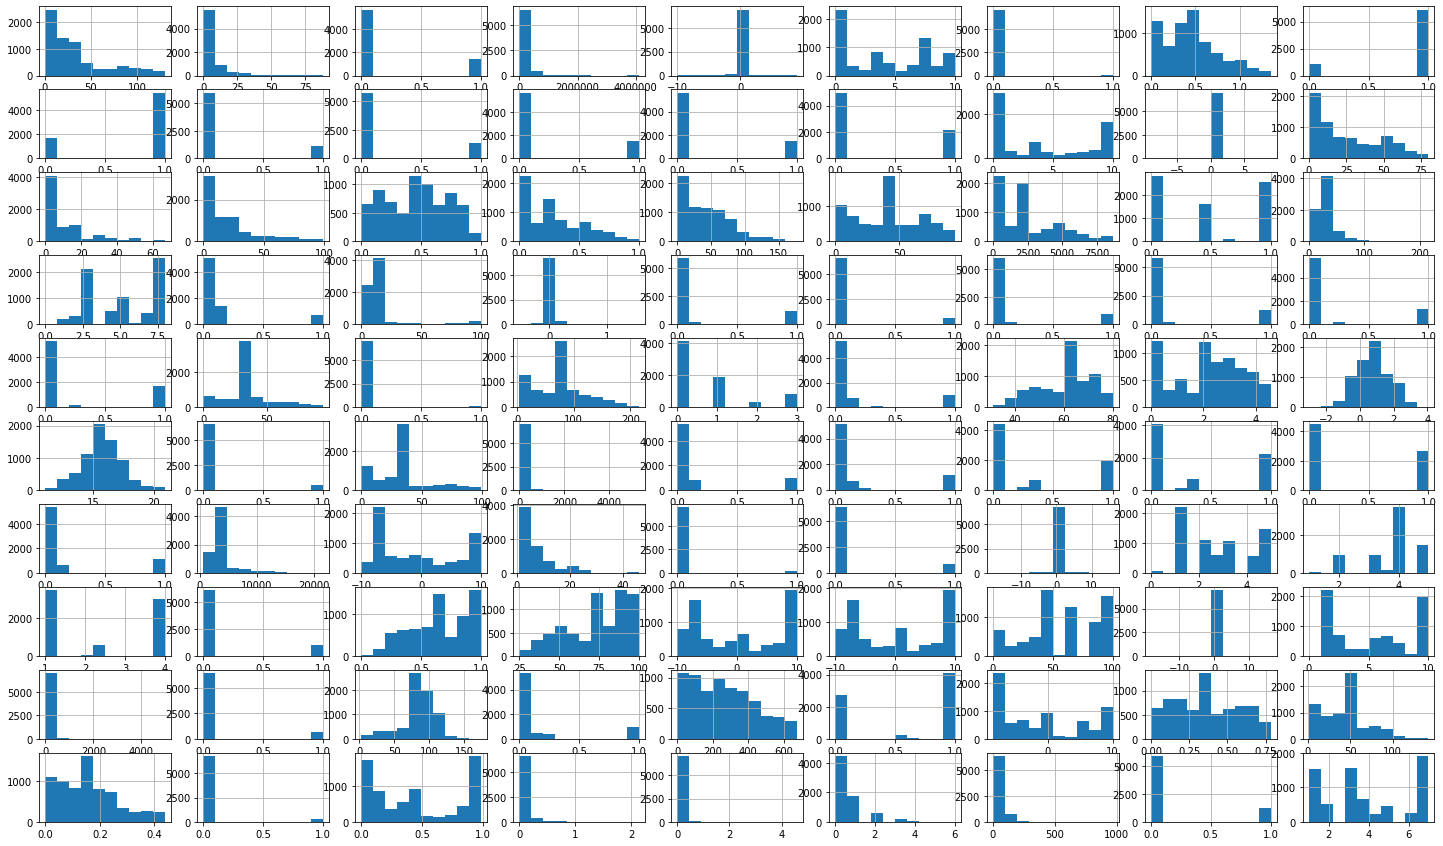

In [14]:
cols = 9
rows = int(X.shape[1] / cols)
fig, axs = plt.subplots(nrows=rows,ncols=cols,figsize=(25,15))
for i in range(len(X.columns)):
    X[X.columns[i]].hist(ax=axs[i//cols,i%cols])

## Steps:

- Identify continuous variables: Use pearson correlation to find which are to be kept
- Identify non-continuous variables (discrete) - Use Chi to determine which should be kept

## Recursive Feature Elimination

### KNN

In [7]:
# knn grid search for roc-auc curve all variables
X, y = data['muchlinski']
scoring='roc_auc'

k_folds = 5
n_neighbors = 9
weights = 'distance'
p = 1

parameters = {'clf__n_neighbors' : n_neighbors,
              'clf__weights' :  weights,
              'clf__p' : p}

param_grid = [parameters]

clf_feature_sele = BalancedRandomForestClassifier(n_estimators=500, class_weight={0:1,1:8}, max_depth=7) # used best params from cv in other notebook (saved in gs_rocauc_brf_all.pkl)
my_rfe = feature_selection.RFECV(clf_feature_sele, step=1, scoring=scoring)

my_knn = neighbors.KNeighborsClassifier()
my_std = preprocessing.StandardScaler()

pipe = pipeline.Pipeline([('std',my_std),('rfe',my_rfe),('clf',my_knn)])
pipe.set_params(**parameters)

cv_score = model_selection.cross_val_score(pipe, X, y, cv=k_folds, scoring=scoring, verbose=10, n_jobs=6)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed: 20.4min remaining: 30.6min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed: 20.5min remaining: 13.7min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 20.8min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 20.8min finished


In [11]:
# pretty crazy, with RFE selection the KNN manages to get 76% auc instead of 66%
np.mean(cv_score)

0.7551350054712788

In [ ]:
gs_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=[scoring])],axis=1)